In [3]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image
import pandas as pd

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns

import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib


### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))

## custom helper modules
import blockworld_helpers as utils

/Users/will/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
importlib.reload(utils)

<module 'blockworld_helpers' from '/Users/will/compositional-abstractions/stimuli/blockworld_helpers.py'>

In [9]:
# setup
block_dims = [(2,1),(1,2)]
block_colors = ['#B32F0A','#0A2FB3']
black = ['#000000','#000000'] # used to display silhouettes
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)

# convert dictionary representations of towers to (hashable) tuple and back
def world_dicts_to_tuples(wd):
    wt = tuple((block['x'],block['y'],block['height'],block['width']) for block in wd)
    return wt

def world_tuples_to_dicts(wt):
    wd = [{'x': block[0],
             'y': block[1],
             'height': block[2],
             'width': block[3]} for block in wt]
    return wd


# helper functions to reduce set of towers

def sort_blocks(stim_list):
    # sort the blocks within a tower to find unique towers
    sorted_list = [sorted(tower, key = lambda block: (block['y'],block['x'],block['height'],block['width'])) # SWAPPED X AND Y POSITIONS IN TUPLE HERE
     for tower in stim_list]
    
    return sorted_list


def align_towers(stim_list):
    # place leftmost block in position 0
    # by subtracting min x ordinate from all x-values

    min_xs = [min([block['x'] for block in tower]) for tower in stim_list]

    aligned_towers = [[{'x': block['x'] - min_x,
       'y': block['y'],
       'height': block['height'],
       'width': block['width']}
      for block in tower] for (tower, min_x) in zip(stim_list, min_xs)]
    
    return aligned_towers

def convert_to_tuples(stim_list):
    return [world_dicts_to_tuples(tower) for tower in stim_list]

def find_unique_towers(stim_list):
    return set(stim_list)


## Create all 4-block towers

In [8]:
# generate stims

max_blocks = 5

stims = {}

# single block in center of world
stims[1] = []

for block in block_dims:
    w = utils.World(block_dims = block_dims,
                block_colors = block_colors)
    w.add_block(block[0], # width
                block[1], # height
                world_center,0)
    stims[1].append(w.get_block_dict()['blocks'])


# add a block in all available locations to all existing towers of n-1 blocks
for n_blocks in range(2,max_blocks+1):
    stims[n_blocks] = []

    # add block in position
    for stim_blocks in stims[n_blocks-1]:
        for block in block_dims:
            for x in range(0, world_width-1):
                #repopulate world
                w = utils.World(block_dims = block_dims,
                                block_colors = block_colors)
                w.populate_from_block_list(stim_blocks)

                #add new block
                w.snap_to_floor(block[0], # width
                            block[1], # height
                            x)
                stims[n_blocks].append(w.get_block_dict()['blocks'])


In [14]:
# how many of each? (not necessarily unique)
_ = [print(str(i) + ' block towers: ' + str(len(stims[i]))) for i in stims.keys()]

1 block towers: 2
2 block towers: 28
3 block towers: 392
4 block towers: 5488
5 block towers: 76832


### Filter duplicate towers

#### sort blocks in tower

In [10]:
stims_sorted_blocks = {i : sort_blocks(stim_list) for _, (i, stim_list) in enumerate(stims.items())}

####  translational invariance- align all towers to left

In [11]:
stims_aligned_blocks = {i : align_towers(stim_list) for _, (i, stim_list) in enumerate(stims_sorted_blocks.items())}

####  find unique towers (i.e. same blocks in same place)

In [12]:
# convert to tuples for easy set operations
tower_tuples = {i : convert_to_tuples(stim_list) for _, (i, stim_list) in enumerate(stims_aligned_blocks.items())}

# now towers are sorted and aligned, find unique towers
unique_towers_tuples = {i : find_unique_towers(stim_list) for _, (i, stim_list) in enumerate(tower_tuples.items())}

# convert back to dictionary for easier tower-operations
unique_towers_dicts = {i : [world_tuples_to_dicts(tower) for tower in stim_list]
                           for _, (i, stim_list) in enumerate(unique_towers_tuples.items())}

In [13]:
print('Unique block towers (same blocks in same place):')
_ = [print(str(i) + ' block: ' + str(len(unique_towers_dicts[i]))) for i in unique_towers_dicts.keys()]

Unique block towers (same blocks in same place):
1 block: 2
2 block: 18
3 block: 162
4 block: 1234
5 block: 8384


## Filter towers based on constraints

#### Create dataframe with properties of towers

In [16]:
df_stim = pd.DataFrame()

for _, (i, stim_list) in enumerate(unique_towers_dicts.items()):
    for stim in stim_list:
        world = utils.worldify(stim) # convert to world object
        
        df_stim = df_stim.append(
        {
            'stim': stim,
            'stim_tuple': world_dicts_to_tuples(stim),
            'n_blocks': i,
            'fully_connected': world.fully_connected(connectivity=1),
            'fully_connected_diag': world.fully_connected(connectivity=2),
            'blocks_above_ground': world.n_blocks_above_ground(),
            'tower_height': world.tower_height(),
            'tower_width': world.tower_width(),
            'two_h_two_v': world.two_h_two_v(),
            'silhouette': world.block_map
        }, ignore_index=True).astype(object)
        
df_stim['fully_connected'] = df_stim['fully_connected'].astype(np.bool)
df_stim['fully_connected_diag'] = df_stim['fully_connected_diag'].astype(np.bool)
df_stim['two_h_two_v'] = df_stim['two_h_two_v'].astype(np.bool)

df_stim['silhouette_str'] = df_stim['silhouette'].apply(utils.convert_to_str)

df_stim = df_stim.sort_values('silhouette_str').reset_index()

In [20]:
# All 4-block towers that meet our contraints
four_block_superset = df_stim[(df_stim.n_blocks==4) &
                                    (df_stim.fully_connected) & 
                                    (df_stim.two_h_two_v) &
                                    (df_stim.blocks_above_ground>=2)]

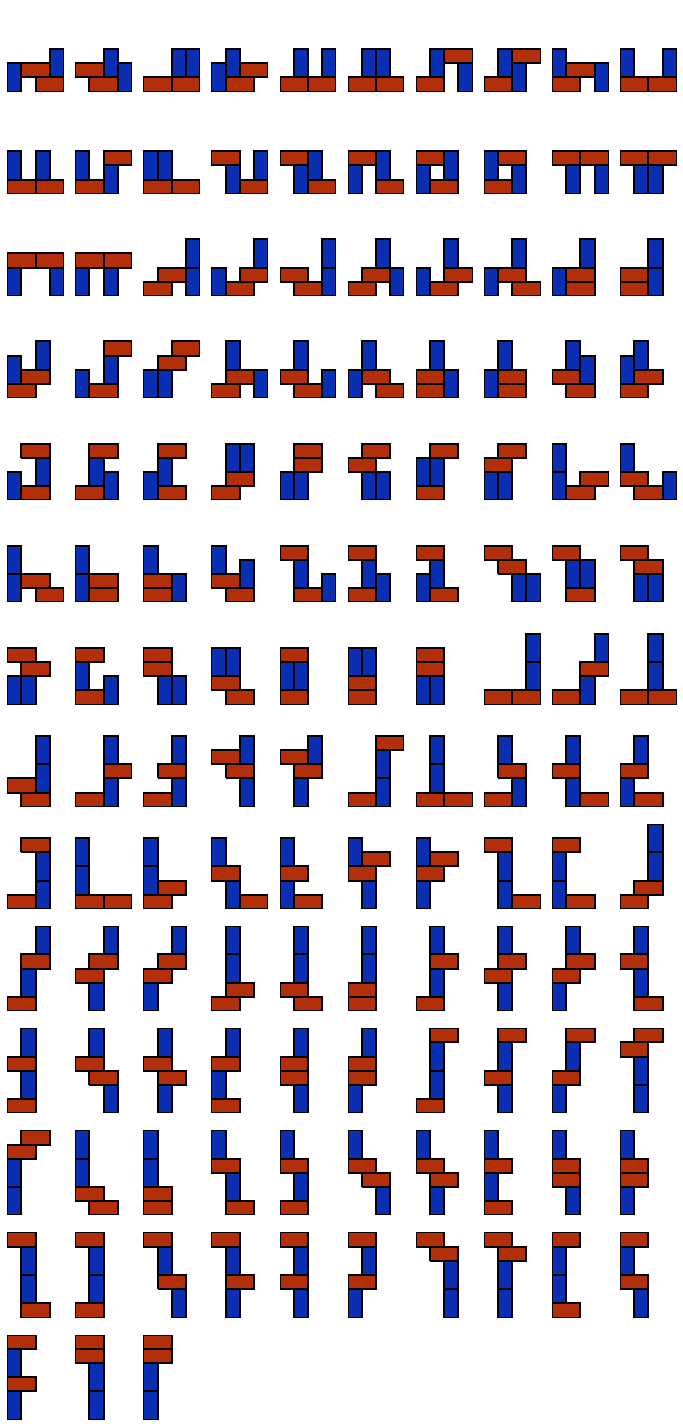

In [21]:
utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
                                  block_colors = block_colors) 
                   for w in four_block_superset['stim']],
                 figsize=(12,26))

In [64]:
# set of silhouettes to be used in prior elicitation study
render = False

silhouette_superset = four_block_superset.groupby('silhouette_str').agg('first').reset_index()
silhouette_superset['tower_number'] = silhouette_superset.index

if render:
    utils.draw_towers([utils.worldify(w, 
                                      block_dims = block_dims, 
                                      block_colors = black) 
                       for w in silhouette_superset['stim']],
                     figsize=(12,26))

## Find tall and wide towers

Tall subset and wide subset to be combined in composite towers.

First find maximal subsets, i.e.

Wide:
- height <=3

Tall:
- height >= 5
- width <= 5

These settings exclude e.g. 'L' used in previous study.

In [38]:
unique_by_silhoutte = False

22 horizontal towers


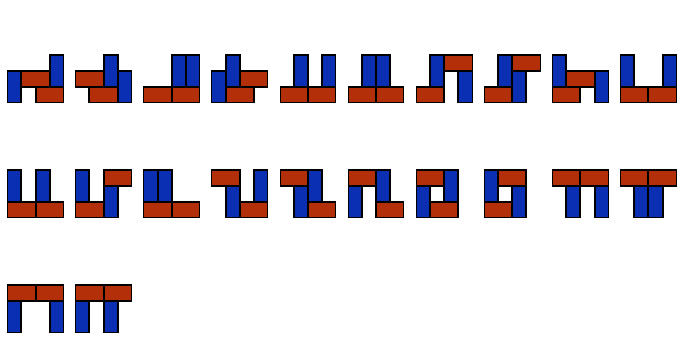

In [65]:
# Wide tower constraints

wide_subset = four_block_superset[(four_block_superset.tower_height <= 3)].reset_index()

# get unique silhouettes

if unique_by_silhoutte:
    wide_subset = wide_subset.groupby('silhouette_str').agg('first').reset_index()

utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in wide_subset['stim']],
                 figsize=(12,6))


print(str(len(wide_subset))+ ' horizontal towers')

56 vertical towers


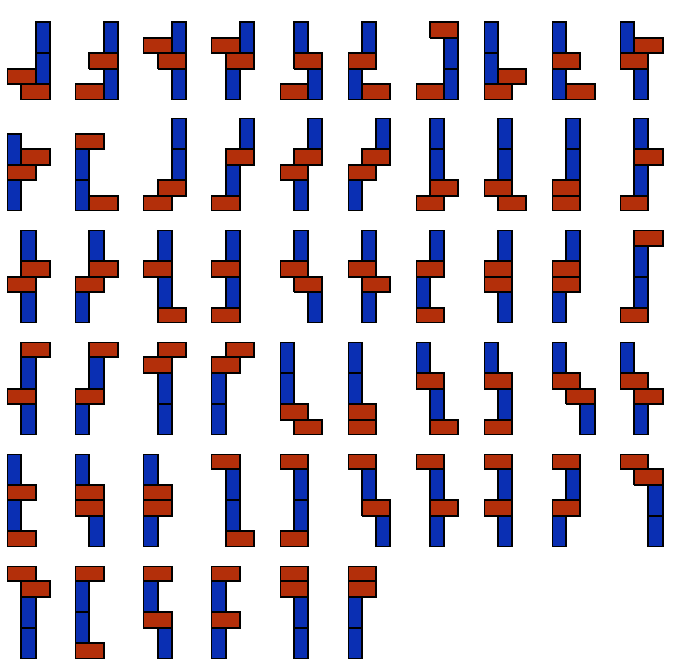

In [66]:
# Tall tower constraints

tall_subset = four_block_superset[(four_block_superset.tower_height >= 5) &
                                  (four_block_superset.tower_width <= 3)].reset_index()

# get unique silhouettes
if unique_by_silhoutte:
    tall_subset = tall_subset.groupby('silhouette_str').agg('first').reset_index()


utils.draw_towers([utils.worldify(w, 
                                  block_dims = block_dims, 
#                                   block_colors = black,
                                  block_colors = block_colors,
                                 ) 
                   for w in tall_subset['stim']],
                 figsize=(12,12))

print(str(len(tall_subset))+ ' vertical towers')

## Combine towers

### Wide towers smooshed directly on top of each other

Notes:
- Square-aperture towers 
    - Special case because a) they're 3-blocks wide not 4, and hence b) aligning them to the left misses out on a bunch of interesting structures.
    - Consider adding a right-aligned square-aperture.


In [49]:
def compose_vertically(stim_a, stim_b): 
    
    world = utils.worldify(stim_a, 
                         block_dims = block_dims, 
                         block_colors = block_colors,)

    tower_a_height = world.tower_height()
    
    still_good = True
    
    for block in stim_b:
        placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
#         print(placed_block.y)
#         print(block['y']+tower_a_height)
#         print('this block good: ' + str(placed_block.y == (block['y'] + tower_a_height)))
        still_good = still_good and (placed_block.y == (block['y'] + tower_a_height))
#         print(still_good)
        
    return (still_good, world)


In [50]:
vert_composition_attempts_matrix = np.array([[compose_vertically(stim_a, stim_b)\
                             for stim_a in wide_subset['stim']]\
                                 for stim_b in wide_subset['stim']])

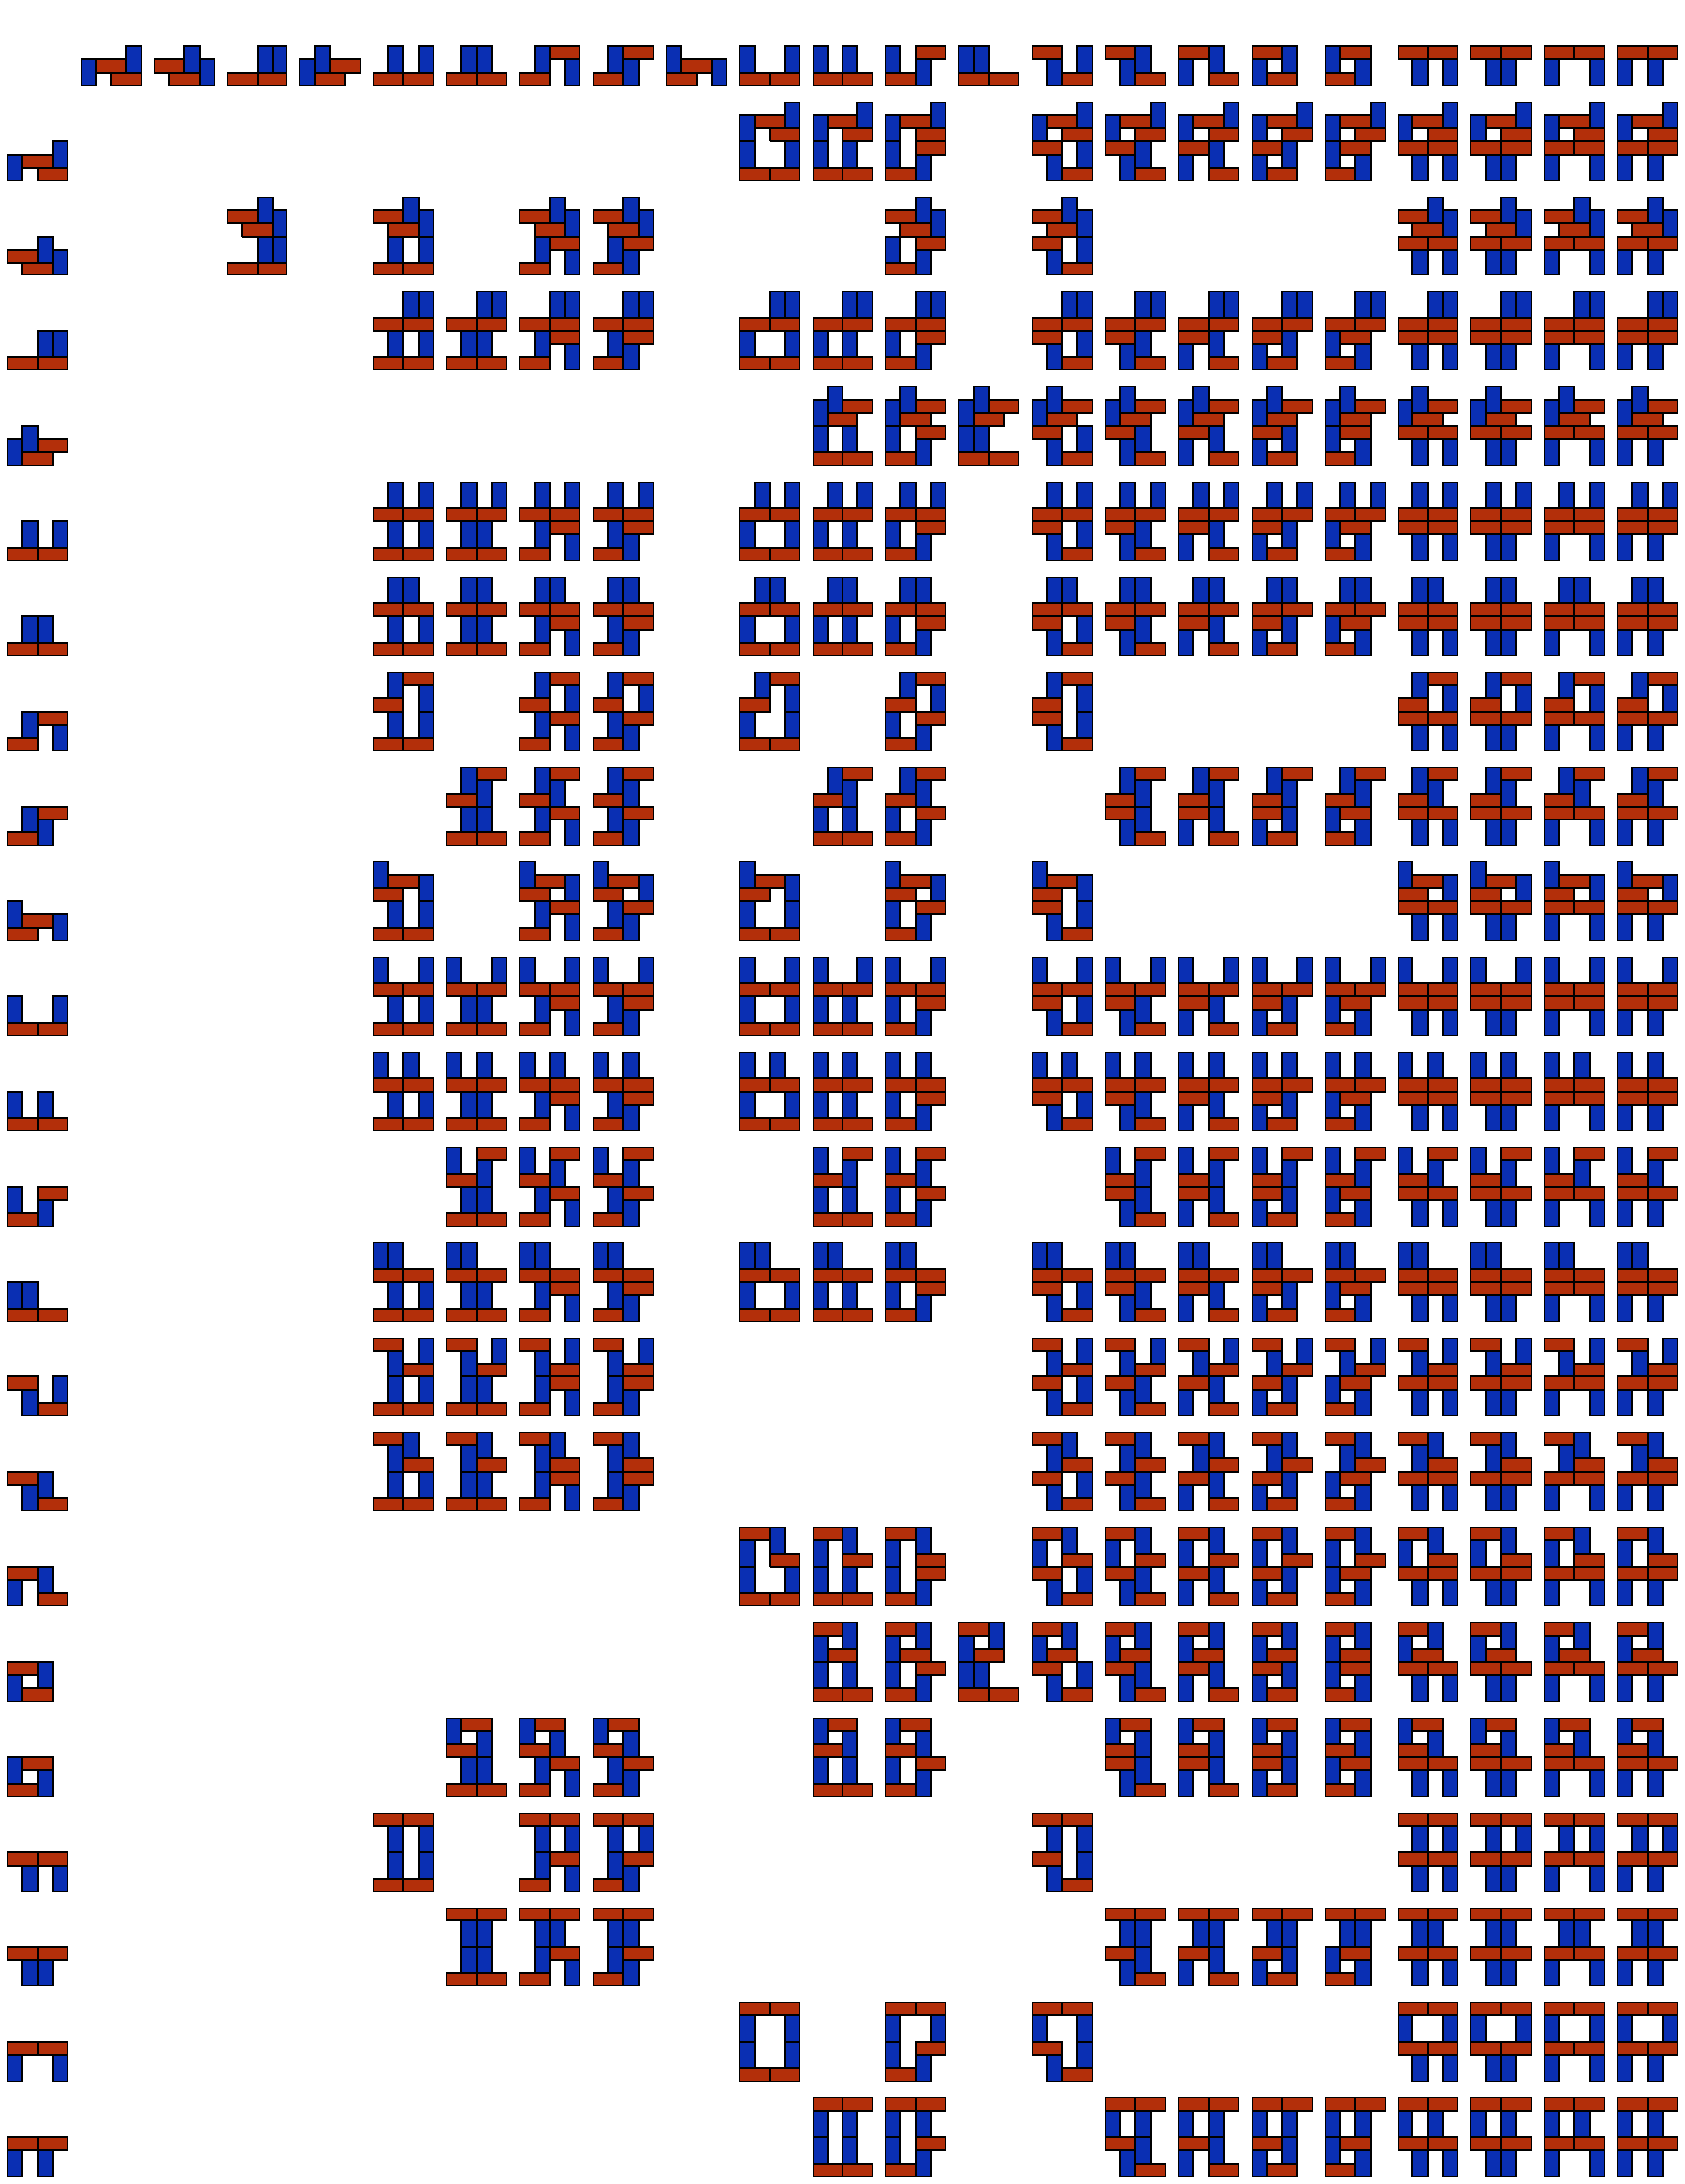

In [51]:
n_towers = vert_composition_attempts_matrix.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 40))

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    #grab tower
    world = utils.worldify(wide_subset['stim'][i], block_dims = block_dims, block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if vert_composition_attempts_matrix[i,j,0]:
            world = vert_composition_attempts_matrix[i,j,1]
            utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,j+1])

### Tall towers smooshed as close as possible

In [52]:
# compose horizontally

def compose_horizontally(stim_a, stim_b): 
    '''
    Composes two tall stimuli by placing them side by side.
    
    Tries placing tower 1, then 2 blocks to the right of it's left-aligned position.

    Rejects tower if width > 4 squares
    
    
    Want to assume that if you can build the towers one after the other, you can build them the other way around
    This should work given that each is an independent standing tower, but:
    NEED TO CHECK THAT IN EXPERIMENT YOU CAN SNAP A BLOCK UNDER ANOTHER IF NEEDED
    
    PRE: stims are maximum 3 wide
    '''
    
    still_good = False
    successful_alignment = None
    
    
    for alignment in [1,2]:
        
        if still_good == False:

            # Try placing left tower first
            world = utils.worldify(stim_a, 
                                 block_dims = block_dims, 
                                 block_colors = block_colors,)

            still_good = True

            for block in stim_b:
                # place block 'alignment' squares to the right of its default position
                placed_block = world.snap_to_floor(block['width'], block['height'], block['x'] + alignment)
                # if it stays at the predefined height, we're good
                still_good = still_good and (placed_block.y == (block['y']))


            if not still_good:
                # Try placing right tower
                
                realigned_tower = [{'x': b['x'] + alignment,
                                     'y': b['y'],
                                     'height': b['height'],
                                     'width': b['width']}
                                              for b in stim_b]

                world = utils.worldify(realigned_tower, 
                                     block_dims = block_dims, 
                                     block_colors = block_colors,)

                still_good = True

                for block in stim_a:
                    # place block 'alignment' squares to the right of its default position
                    placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
                    # if it stays at the predefined height, we're good
                    still_good = still_good and (placed_block.y == (block['y']))
                    
                still_good = still_good and world.tower_width() <=4
                    
                
                
                if not still_good:
                    # try sorting
                    
                    stim_a_copy = stim_a.copy()
                    
                    sorted_stims = sort_blocks([stim_a_copy + realigned_tower])[0]

                    world = utils.World(block_dims = block_dims, 
                                        block_colors = block_colors,)
                    still_good = True

                    for block in sorted_stims:
                        # place block 'alignment' squares to the right of its default position
                        placed_block = world.snap_to_floor(block['width'], block['height'], block['x'])
                        # if it stays at the predefined height, we're good
                        still_good = still_good and (placed_block.y == (block['y']))
                
                


            still_good = still_good and world.tower_width() <=4
            
            if still_good:
                successful_alignment = alignment
            

    return (still_good, world, successful_alignment)



In [67]:
horz_composition_attempts_matrix = np.array([[compose_horizontally(stim_a, stim_b)\
                             for stim_a in tall_subset['stim']]\
                                 for stim_b in tall_subset['stim']])

In [ ]:
n_towers = horz_composition_attempts_matrix.shape[0]

fig, axs = plt.subplots(n_towers+1, n_towers+1, figsize = (30, 36) )

for ax in axs.flatten():
    ax.axis('off')

# Add tower-chunks as titles
for i in range(0, n_towers):
    world = utils.worldify(tall_subset['stim'][i], block_dims = block_dims, block_colors = block_colors)
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,0])
    utils.tower_subplot(utils.patches_for_world(world.blocks), axs[0,i+1])
    
# iterate over towers
for i in range(0, n_towers):
    for j in range(0, n_towers):
        if horz_composition_attempts_matrix[i,j,0]:
            world = horz_composition_attempts_matrix[i,j,1]
            utils.tower_subplot(utils.patches_for_world(world.blocks), axs[i+1,j+1])